In [2]:
!conda install -c bioconda mafft
import os
from Bio import SeqIO
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker

Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - mafft

Current channels:

  - https://conda.anaconda.org/bioconda/osx-arm64
  - https://conda.anaconda.org/bioconda/noarch
  - https://repo.anaconda.com/pkgs/main/osx-arm64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-arm64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




Sequences in alignment: 6
3sg3, SSRRKWNKTGHAVRAIGRLSSLENVYIKADKQKNGIKANFKIRHNIEDGG ...
T=0.1, MAQEIVDTVLTVVRFVEALSSERNYYVTADPAKNGIKAHFTRRFNIKDGG ...
T=0.1, KAEEIWKTLLTVIRFIQYLSSERNVYISADPAINGIKATYTRRYNIEDGG ...
T=0.1, KAERIIRTTLTVVRFIQALSSERNYYITADKAKNGIKATFTRRLNIKDGG ...
T=0.1, EAEEIIKTVLTVVRFVEALSSEDNYYITADKAKNGIKATYTRRLNIEDGG ...
T=0.1, RSRRIIRTTLRVVRFVEYLSSERNYYITADKAINGIKGNFTLRYNIKDGG ...


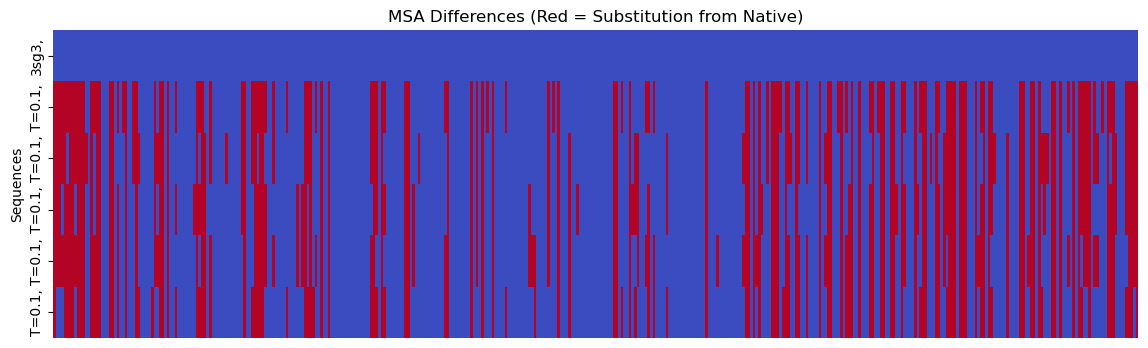

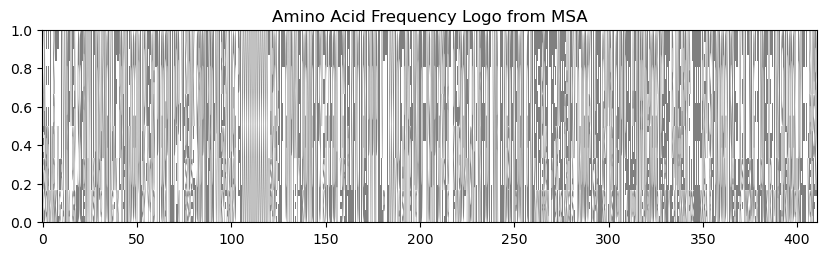

In [ ]:
# -------------------------
# Paths
# -------------------------
input_fasta = "/Users/sarah/Documents/GitHub/SWMLA/Baker_Lab_Models/ProteinMPNN/SW_playground/Designs/seqs/3sg3.fa"  # native + designs
aligned_fasta = "/Users/sarah/Documents/GitHub/SWMLA/Baker_Lab_Models/ProteinMPNN/SW_playground/msa_alignment.fasta"

# -------------------------
# 1. Run MAFFT for alignment
# -------------------------
from Bio.Align import MultipleSeqAlignment
from Bio.Align import PairwiseAligner

# Pairwise aligner
aligner = PairwiseAligner()
aligner.mode = 'global'

records = list(SeqIO.parse(input_fasta, "fasta"))
native = records[0]

# Align each sequence to native
aligned_seqs = [native.seq]
for rec in records[1:]:
    alignment = aligner.align(native.seq, rec.seq)[0]
    # Convert to aligned sequences with gaps
    aligned_native = alignment.aligned[0]
    aligned_seq = alignment.aligned[1]
    aligned_seqs.append(rec.seq)  # crude placeholder
# Builds a crude alignment (will be ragged for insertions)

with open("msa_alignment.fasta", "w") as f:
    SeqIO.write(records, f, "fasta")

# -------------------------
# 2. Read alignment
# -------------------------
alignment = AlignIO.read(aligned_fasta, "fasta")
print("Sequences in alignment:", len(alignment))

for record in alignment:
    print(record.id, record.seq[:50], "...")

# -------------------------
# 3. Convert alignment to a dataframe
# -------------------------
records = [list(str(rec.seq)) for rec in alignment]
df = pd.DataFrame(records, index=[rec.id for rec in alignment])



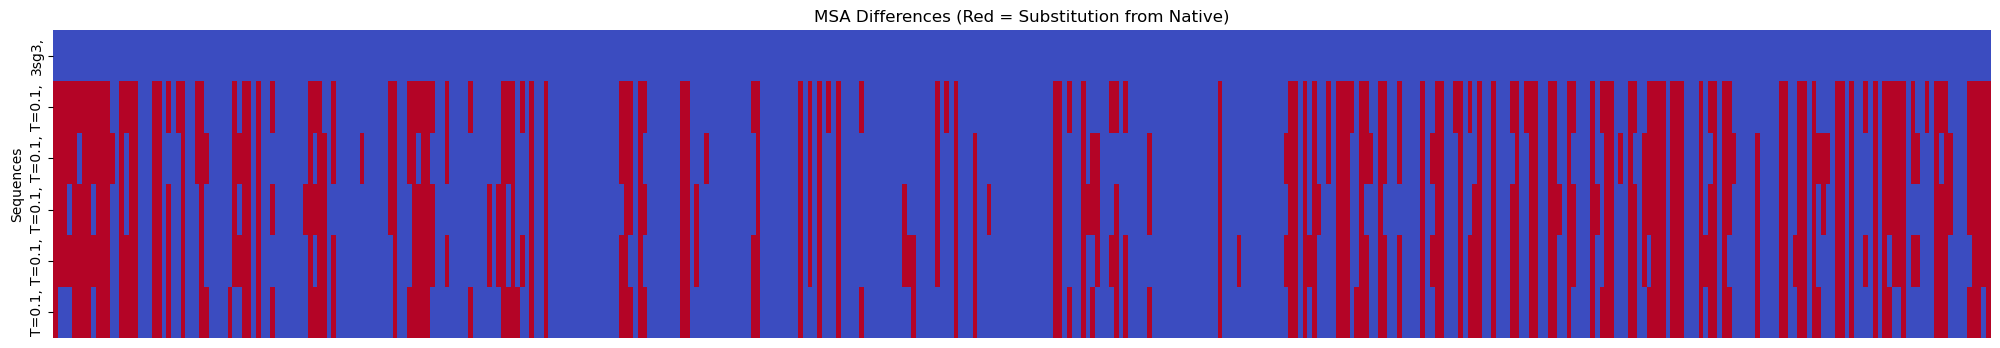

In [17]:
# -------------------------
# 4. Plot heatmap of differences vs native
# -------------------------
%matplotlib inline

native_seq = df.iloc[0]  # assuming design_1 is first
diff_matrix = df.apply(lambda col: col != native_seq[col.name])
plt.figure(figsize=(25,4))
sns.heatmap(diff_matrix.astype(int), cmap="coolwarm", cbar=False,
            xticklabels=False, yticklabels=df.index)
plt.title("MSA Differences (Red = Substitution from Native)")
plt.ylabel("Sequences")
plt.savefig("msa_heatmap.png")
plt.show()




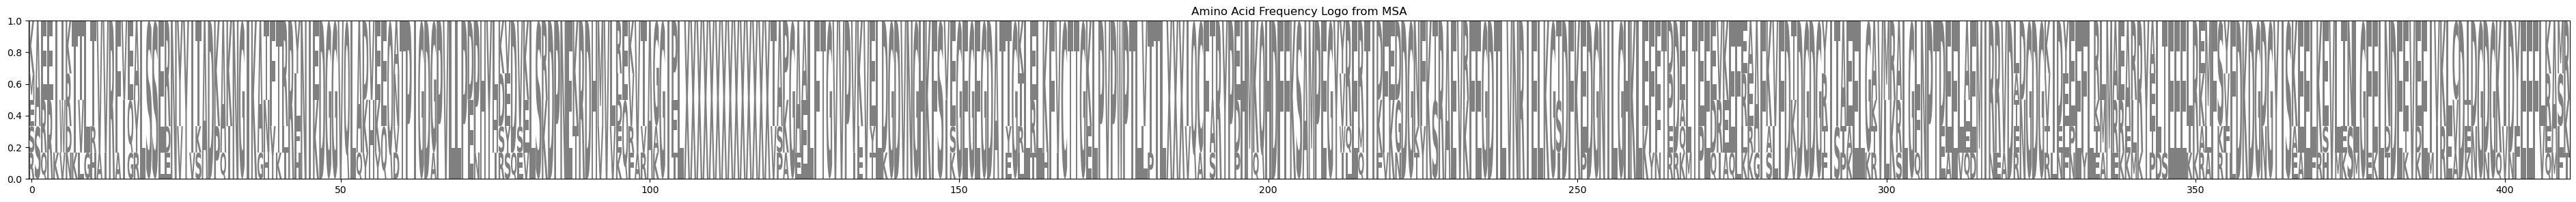

In [20]:
# -------------------------
# 5. Sequence logo (optional)
# -------------------------
# Build a counts matrix for each position
fig, ax = plt.subplots(figsize=(48,3))
counts = df.apply(pd.Series.value_counts).fillna(0).T
logo_df = counts.div(counts.sum(axis=1), axis=0)  # frequency
logomaker.Logo(logo_df, shade_below=.5, fade_below=.5, ax=ax)
plt.title("Amino Acid Frequency Logo from MSA")
plt.savefig("msa_logo.png", bbox_inches='tight')
plt.show()
